In [1]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random


C:\Users\Rock_\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
def load_photos(directory):
    images = []
    labels_speed = []
    labels_dir = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 192))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value_speed = int(name.split('_')[0])
        value_dir = int(name.split('_')[1])
        labels_speed.append(value_speed)
        labels_dir.append(value_dir)
        images.append(image)
    return images, labels_speed, labels_dir

In [8]:
#dataset = "Pics/Auto"
dataset = "../../Datasets_Axionable/ironcar_pics"

In [9]:
# load images from both train and test groups
directory = '../../' + dataset
images, labels_speed, labels_dir = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels: %d' % nb_images)

Loaded Images and labels: 17547


In [10]:
images = np.array(images)
images /= 255

In [11]:
#convert datas to dummyvalues
labels_speed = np.array(pd.get_dummies(labels_speed))
labels_dir = np.array(pd.get_dummies(labels_dir))

In [12]:
labels_speed[4200], labels_dir[4200]

(array([1], dtype=uint8), array([0, 0, 1, 0, 0], dtype=uint8))

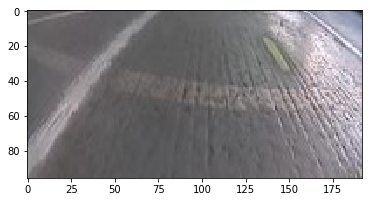

In [13]:
plt.imshow(images[4200])

In [14]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers

In [26]:
K.clear_session()
############################################################# Simple Dir Model  

img_in = Input(shape=(96, 192, 3), name='img_in')

x = img_in

x = Convolution2D(6, (16,16), strides=(8,8), activation='relu', padding='same')(x)
x = Dropout(.1)(x)
x = Convolution2D(12, (16,16), strides=(8,8), activation='relu', padding='same')(x)
x = Dropout(.1)(x)
flat = Flatten()(x)
out = Dense(5, activation='softmax')(flat)

model = Model(inputs=[img_in], outputs=[out])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

ValueError: Negative dimension size caused by subtracting 16 from 14 for 'conv2d_2/convolution' (op: 'Conv2D') with input shapes: [?,14,23,6], [16,16,6,12].

In [22]:
h = model.fit(images, labels_dir, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Train on 14037 samples, validate on 3510 samples
Epoch 1/10
14037/14037 [==============================] - 16s 1ms/step - loss: 0.0512 - acc: 0.9828 - val_loss: 0.0332 - val_acc: 0.9912
Epoch 2/10
14037/14037 [==============================] - 17s 1ms/step - loss: 0.0511 - acc: 0.9825 - val_loss: 0.0319 - val_acc: 0.9912
Epoch 3/10
14037/14037 [==============================] - 19s 1ms/step - loss: 0.0516 - acc: 0.9820 - val_loss: 0.0305 - val_acc: 0.9903
Epoch 4/10
14037/14037 [==============================] - 18s 1ms/step - loss: 0.0448 - acc: 0.9855 - val_loss: 0.0297 - val_acc: 0.9906
Epoch 5/10
14037/14037 [==============================] - 16s 1ms/step - loss: 0.0425 - acc: 0.9848 - val_loss: 0.0318 - val_acc: 0.9915
Epoch 6/10
14037/14037 [==============================] - 16s 1ms/step - loss: 0.0417 - acc: 0.9860 - val_loss: 0.0293 - val_acc: 0.9915
Epoch 7/10
14037/14037 [==============================] - 17s 1ms/step - loss: 0.0417 - acc: 0.9865 - val_loss: 0.0330 - val_acc:

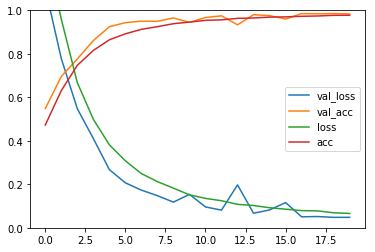

In [18]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [23]:
model.save('model_dir.h5')

In [15]:
K.clear_session()
############################################################# Simple Speed Model  

img_in = Input(shape=(18, 192, 3), name='img_in')

x = img_in

x = Convolution2D(6, (16,16), strides=(8,8), activation='relu', padding='same')(x)
x = Dropout(.1)(x)
flat = Flatten()(x)
out = Dense(2, activation='softmax')(flat)

model = Model(inputs=[img_in], outputs=[out])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 18, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 143, 2)         1946      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 143, 2)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 286)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 574       
Total params: 2,520
Trainable params: 2,520
Non-trainable params: 0
_________________________________________________________________


In [16]:
h = model.fit(images[:, :78, :, :], labels_speed, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

ValueError: Error when checking target: expected dense_1 to have shape (2,) but got array with shape (1,)

In [ ]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [ ]:
model.save('model_speed_dir.h5')

In [24]:
K.clear_session()
############################################################# Multitask Model  

img_in = Input(shape=(96, 192, 3), name='img_in')

x = img_in

x = Convolution2D(6, (16,16), strides=(8,8), activation='relu', padding='same')(x)
x = Dropout(.1)(x)
x = Convolution2D(12, (16,16), strides=(8,8), activation='relu', padding='same')(x)
x = Dropout(.1)(x)
flat = Flatten()(x)
out_speed = Dense(2, activation='softmax')(flat)
out_dir = Dense(5, activation='softmax')(flat)

model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 96, 192, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 24, 6)    4614        img_in[0][0]                     
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 12, 24, 6)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 3, 12)     18444       dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [ ]:
h = model.fit(images, [labels_speed, labels_dir], batch_size=128, epochs=20, verbose=1, validation_split=0.2)

In [ ]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [ ]:
model.save('model_multi.h5')